Тех часть


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

# инициализируем plotly
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)


In [2]:
from prophet import Prophet


In [3]:
df=pd.read_csv('fishes.csv')

- Для проверки гипотез и построения модели сократи выборку до Дании

Посмотрим долю вылова из каждой рыбы по годам

In [4]:
df.drop('Unnamed: 0', axis=1,inplace=True)
df=df[df.fishing_entity=="Denmark"]

In [5]:
date=df.groupby(by=['year','commercial_group']).sum().reset_index()
date=date.assign(weight=date.catch_sum/date.groupby('year').catch_sum.transform('sum'))

In [6]:
d= date.melt(['commercial_group', 'year'] , value_vars = 'weight' , var_name='a', value_name='b')

In [7]:
d

,commercial_group,year,a,b
0,Cod-likes,1950,weight,1.252388e-01
1,Crustaceans,1950,weight,9.393917e-03
2,Flatfishes,1950,weight,3.200983e-01
3,Herring-likes,1950,weight,9.142129e-02
4,Molluscs,1950,weight,1.337884e-01
...,...,...,...,...
731,Perch-likes,2018,weight,7.092484e-02
732,"Salmon, smelts, etc",2018,weight,4.341586e-04
733,Scorpionfishes,2018,weight,2.028655e-03
734,Sharks & rays,2018,weight,2.508286e-04


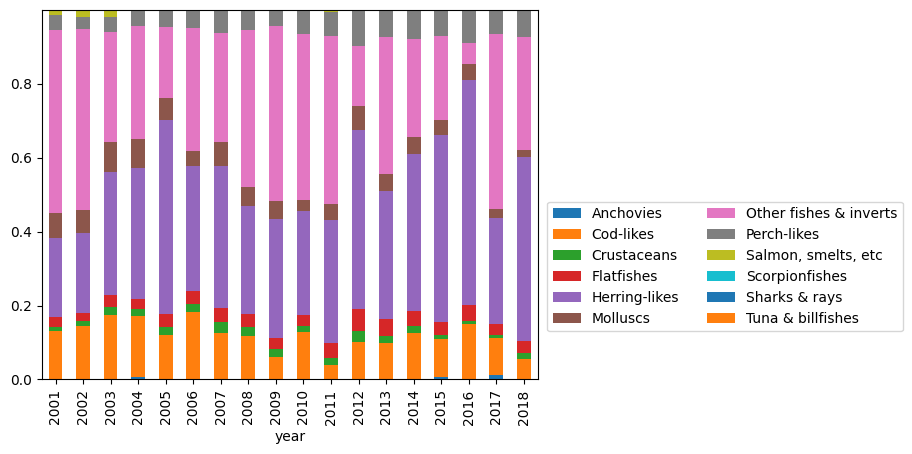

In [8]:
bar_plot2 = d[d.year>2000].pivot(index='year', columns='commercial_group', values= 'b').plot.bar(stacked=True)
plt.legend(ncol=2, loc="upper right", frameon=True, bbox_to_anchor=(1.75, 0.5))
plt.show()

In [9]:
d= date.melt(['commercial_group', 'year'] , value_vars = 'weigth' , var_name='a', value_name='b')
for_test = d[d.year>2000].pivot(index='year', columns='commercial_group', values= 'b').T.fillna(0)


Проверим гипотезу о равенстве среднему вылрову

In [10]:
from scipy.stats import ttest_1samp
mean_catch = for_test.mean()
last_year_catch = for_test.iloc[:,-1]

alpha = 0.05
ttest_results = pd.DataFrame()
for species in for_test.index:
    ttest, p_value = ttest_1samp(for_test.loc[species], last_year_catch[species])
    reject_null = 'Yes' if p_value < alpha else 'No'
    ttest_results = ttest_results.append(pd.DataFrame({
          'species': [species],
          'p_value': [p_value],
          't_statistic': [ttest],
        'H0_rejected': [reject_null]
      }))


ttest_results

,species,p_value,t_statistic,H0_rejected
0,Anchovies,9.448258e-02,1.771026,No
0,Cod-likes,3.818679e-06,6.687602,Yes
0,Crustaceans,2.815391e-02,2.399518,Yes
0,Flatfishes,6.238378e-01,0.499489,No
0,Herring-likes,2.205025e-04,-4.668428,Yes
0,Molluscs,6.163628e-07,7.695680,Yes
0,Other fishes & inverts,2.840186e-01,1.106272,No
0,Perch-likes,1.036786e-02,-2.881173,Yes
0,"Salmon, smelts, etc",5.348275e-02,2.074982,No
0,Scorpionfishes,1.945229e-04,-4.727505,Yes


Посмотрим как менялачсь цена на рыб из года в год

In [11]:
prices=df.groupby(by=['year', 'commercial_group']).sum().reset_index()

In [12]:
prices['prices']=prices.real_value/prices.catch_sum /100

<Axes: xlabel='year', ylabel='prices'>

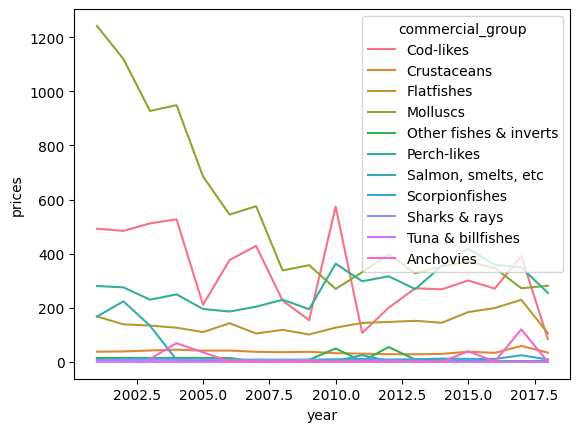

In [13]:
sns.lineplot(x='year', y='prices', data=prices[(prices.year>2000) & (prices.commercial_group != "Herring-likes")], hue='commercial_group')

Построим мо которая буджет предсказывать обьем вылова в Дании

In [14]:
pred=df.groupby(by='year').sum()
pred.drop('rfmo_id', axis=1, inplace= True)
pred.drop('real_value', axis=1, inplace= True)

In [15]:
plotly_df(pred)

## Прогноз улова рыбы

In [16]:
predictions = 15
df1 = pred.reset_index()
df1['year'] = pd.to_datetime(df1.year, format='%Y')
df1.columns = ['ds', 'y']

In [17]:
df1

,ds,y
0,1950-01-01,149961.184040
1,1951-01-01,178877.899193
2,1952-01-01,203521.289708
3,1953-01-01,228292.620669
4,1954-01-01,264481.735781
...,...,...
64,2014-01-01,662167.620470
65,2015-01-01,779566.406438
66,2016-01-01,561554.744375
67,2017-01-01,783932.069128


In [18]:
train_df = df1[:-predictions] 

In [19]:
m = Prophet(seasonality_mode='multiplicative').fit(train_df)
future = m.make_future_dataframe(periods=predictions, freq="AS")
fcst = m.predict(future)


23:05:10 - cmdstanpy - INFO - Chain [1] start processing
23:05:10 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
cmp_df = fcst.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df1.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 29.491152286325704
MAE 187706.8849846026


Получили MAPE - 29 %

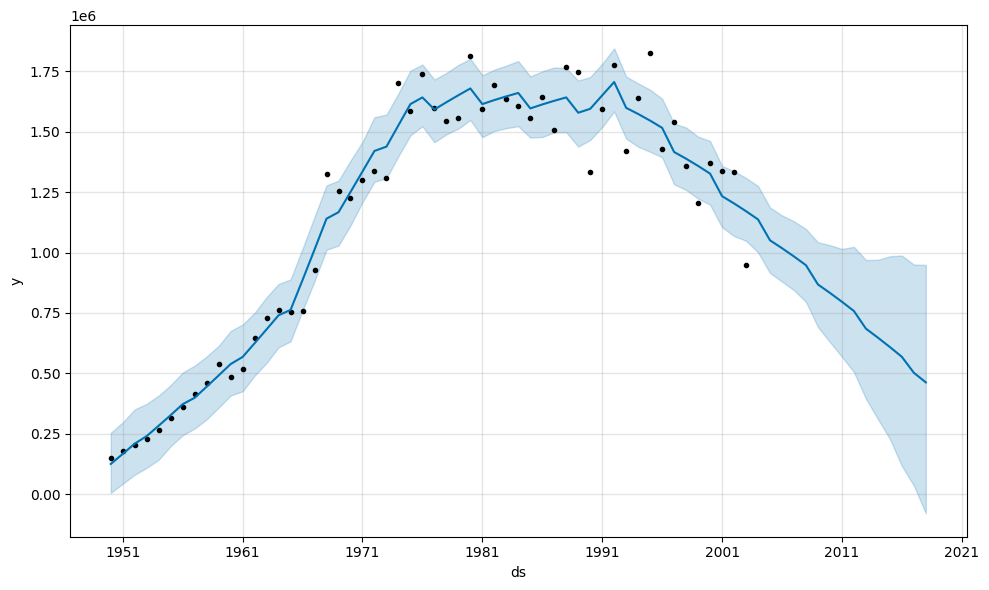

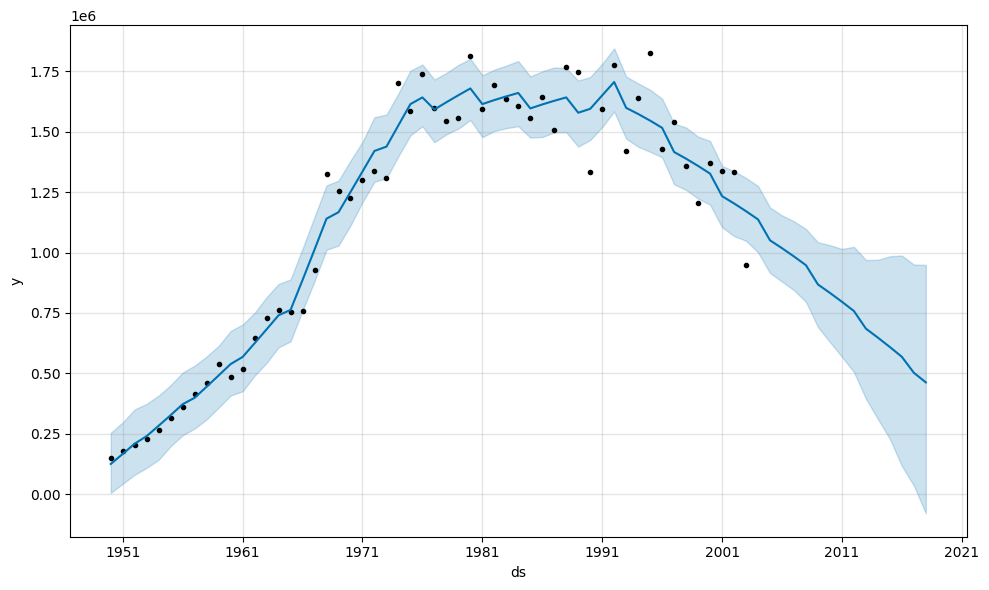

In [21]:
m.plot(fcst)

In [22]:
def show_forecast(cmp_df, num_predictions, num_values):

    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="burlywood"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')


    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

   
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="lightblue"),
        line=dict(width=0),
        mode='lines')

    # фактические значения
    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )


    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='улов'),
        title='Вылов рыбы',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, predictions, 200)

Я выбрала метрики MAE и MAPE для оценки модели машинного обучения по объему вылова рыбы, потому что они обе являются надежными показателями точности прогнозирования в случае временных рядов. 
 - MAE измеряет абсолютную ошибку прогнозирования, что позволяет оценить точность прогнозов в конкретном временном ряду. 
 - MAPE, с другой стороны, измеряет процентную ошибку прогнозирования, что делает его полезным для сравнения точности прогнозов различных временных рядов.

## Прогноз стоимости рыбы

In [23]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [24]:
den = df[['common_name', 'functional_group', 'commercial_group', 'sector_type', 'catch_status', 'reporting_status', 'gear_name', 'catch_sum', 'real_value']]

In [25]:
X = den.iloc[:,:-1]
y = den['real_value']

In [26]:
catboost = CatBoostRegressor(n_estimators=200, cat_features = ['common_name', 'functional_group', 'commercial_group', 'sector_type', 'catch_status', 'reporting_status', 'gear_name'])
cv_r2 = cross_val_score(catboost, X, y, cv=3, scoring='r2')

Learning rate set to 0.273643
0:	learn: 1994196245.1142991	total: 171ms	remaining: 34.1s
1:	learn: 1804135519.2948942	total: 201ms	remaining: 19.9s
2:	learn: 1652895314.8616140	total: 223ms	remaining: 14.6s
3:	learn: 1560496727.9670134	total: 245ms	remaining: 12s
4:	learn: 1498712003.7658653	total: 273ms	remaining: 10.6s
5:	learn: 1467279033.6932020	total: 295ms	remaining: 9.52s
6:	learn: 1448913736.0778151	total: 317ms	remaining: 8.74s
7:	learn: 1439904219.9899008	total: 339ms	remaining: 8.13s
8:	learn: 1432376560.1425152	total: 359ms	remaining: 7.62s
9:	learn: 1406344237.7473826	total: 381ms	remaining: 7.25s
10:	learn: 1400776365.6704357	total: 400ms	remaining: 6.88s
11:	learn: 1392813438.7149131	total: 425ms	remaining: 6.66s
12:	learn: 1386923876.6968277	total: 447ms	remaining: 6.43s
13:	learn: 1380296500.6959651	total: 470ms	remaining: 6.25s
14:	learn: 1376472880.3066769	total: 489ms	remaining: 6.03s
15:	learn: 1375607484.5059242	total: 513ms	remaining: 5.89s
16:	learn: 1373313297.

In [179]:
print(cv_r2)

[0.44237983 0.23789531 0.25539811]


Был сделан прогноз общей стоимости рыбы в Дании на основании имеющихся данных по всем годам с помощью градиентного бустинга. Модель показала лучшую объясняющую способность на кросс-валидации при первой итерации - 44%.